# Model comparison 

This notebook is to compare all six models that have been investigated:
- K-neighbors 
- Decision Trees
- Logistic Regression 
- Linear SVM
- Random Forests 
- Multilayer perceptrons 

Definitions: using a confusion matrix the following measures of success can be calculated: 

TP = true positives
TN = true negatives 
FP = false positives 
FN = false negatives 

Accuracy: Overall how often is the classifier correct? (TP+TN)/total

Precision: When predicted yes, how often is it correct?
(TP/predicted yes)

Recall:  When it's actually yes, how often does it predict yes?
TP/actual yes 

f1_score: A weighted average of the true positive rate (recall) and precision 

ROC Curve: This is a commonly used graph that summarizes the performance of a classifier over all possible thresholds. It is generated by plotting the True Positive Rate (y-axis) against the False Positive Rate (x-axis) as you vary the threshold for assigning observations to a given class

In [1]:
#import relevant libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import preprocessing_ml as pp
import seaborn as sn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score



Importing the preprocessing module for the Exeter NatSci Machine Learning Group.....
Successfully imported the preprocessing module


In [2]:
#import test dataset and framingham score system 
dataset = pd.read_csv('framingham.csv')
df_fram = pd.read_csv("Framingham Score/fram_risk.csv",index_col="index")[['TenYearCHD','fram_percent']]

In [3]:
#performance algorithm from Logistic Regression kernal 
def cross_val(model, X, Y, scoring = ['accuracy','precision','recall','f1'], cv=5):
    
   #See https://scikit-learn.org/stable/modules/model_evaluation.html for list of allowed scoring params 
    from sklearn.model_selection import cross_val_score 
    
    print('\nCrossvalidation score for {} splits:\n'.format(cv))   
    
    cv_results = pd.DataFrame(columns=scoring)
    for measure in scoring:
        cv_results[measure] = cross_val_score(model, X, Y, scoring = measure, cv=cv)
    
    #print("Cross validation Accuracy:\n", cv_results.mean(),"\nCross validation STDEV:\n" , cv_results.std())
    return cv_results.mean()

def performance(model,X_test,y_test,cutoff=0.5,v=0,output='Accuracy'):
    from sklearn.preprocessing import binarize
    from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

    if model == 'fram': # cheap and dirty fix for framingham data needing different processing
        y_pred = X_test > cutoff*100 
    else:
        y_pred = model.predict_proba(X_test)
        y_pred = binarize(y_pred,cutoff)[:,1]
    
    if v == 1: 
        print('\n========\nCuttoff: ',cutoff)
        print('Confusion Matrix:')
        cm=confusion_matrix(y_test,y_pred)
        conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
        print(confusion_matrix(y_test,y_pred))
    
        print('Accuracy: {:.2f}%'.format(accuracy_score(y_test,y_pred)*100))
        print('f1 score: {:.2f}%'.format(f1_score(y_test,y_pred)*100))
        print('precision score: {:.2f}%'.format(precision_score(y_test,y_pred)*100))
        print('recall score: {:.2f}%'.format(recall_score(y_test,y_pred)*100))
        
        print(classification_report(y_test,y_pred))
    

    if output == 'Accuracy':
         return accuracy_score(y_test,y_pred)
    elif output == 'Precision':
         return precision_score(y_test,y_pred)
    elif output == 'Recall':
         return recall_score(y_test,y_pred)
    elif output == 'f1_score':
         return f1_score(y_test,y_pred)
    elif output == 'All':
        a = [accuracy_score(y_test,y_pred), precision_score(y_test,y_pred),
                      recall_score(y_test,y_pred), f1_score(y_test,y_pred)]
        return a




# Functions for each model:

In [4]:
#function for the Framingham model currently used by doctors 
def fram_analysis(df_fram, v=0):
    range_x = np.arange(0.05, 1, 0.02)
    results_fram =[]
    
    for cutoff in range_x:
        results_fram.append(performance('fram', df_fram['fram_percent'], df_fram['TenYearCHD'], cutoff=cutoff, output='All'))
    results_fram = pd.DataFrame(results_fram, columns=['accuracy', 'precision', 'recall', 'f1'])
    
    return results_fram

In [5]:
#function created with the optimal conditions for the k_neighbors algorithm - SMOTE still needed to add
def k_neighbors_opt(dataset, v=0):
    '''Do k_neighbors  fitting and print information about the success of the fitting
    dataset = dataset which will be used to train and test data
    v (optional, default = 0): int (0 or 1) verbose'''
    
    from sklearn.neighbors import KNeighborsClassifier
    print('\nOptimising parameters...\n')
    
    dataset_t = pp.chose_features(dataset, n_features=12) # choose n features
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.scale_data(dataset_t, 'standard', v=1 ) #scale data using minmax function 
    X_train, X_test, y_train, y_test = pp.smote(dataset_t) # split dataset
    
    print('\nCalculating K_neighbors ...\n')
    KN = KNeighborsClassifier(n_neighbors =16)
    KN.fit(X_train, y_train)
    y_pred = KN.predict(X_test)
    
    if v == 1:
        print('\nRunning K_neighbors algorithm...\n')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
        print('Calculating metrics for ranging cutoff...')
        range_x = np.arange(0.05, 1, 0.02)
        results_KN = []

        for cutoff in range_x:
            results_KN.append(performance(KN, X_test, y_test,cutoff=cutoff, output='All'))
        results_KN = pd.DataFrame(results_KN,columns=['accuracy','precision','recall','f1'])
    
    #probability score for ROC curve:
    y_pred_prob_yes=KN.predict_proba(X_test)
    
    #confusion matrix:
    cm=confusion_matrix(y_test,y_pred)


    return results_KN, y_pred_prob_yes, y_test, cm
    

In [6]:
#function created with optimised SVM algorithm - SMOTE still needs to be added 
def SVM_opt(dataset, v=0):
    '''Do linear support vector machine fitting and print information about the success of the fitting 
    dataset = dataset which will be used to train and test data 
    v (optional, default =0): int (0 or 1) verbose'''
    
    print('\nOptimising parameters...\n')
    dataset_t = pp.chose_features(dataset, n_features=12)
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.scale_data(dataset_t, 'minmax', v=1)
    X_train, X_test, y_train, y_test = pp.smote(dataset_t) # split dataset
    
    from sklearn.svm import SVC
    
    print('\nCalculating Support vector machine ..\n')
    SVM = SVC(C=3, random_state=0, probability=True)
    SVM.fit(X_train, y_train) 
    y_pred = SVM.predict(X_test)
    
    if v == 1: 

        print('Running support vector machine...')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
        print('\nCalculating metrics for ranging classification...')
        range_x = np.arange(0.05, 1, 0.02)
        results_SVM =[]
        for cutoff in range_x:
            results_SVM.append(performance(SVM, X_test, y_test,cutoff=cutoff, output='All'))
        results_SVM = pd.DataFrame(results_SVM,columns=['accuracy','precision','recall','f1']) 

    #probability score for ROC curve:    
    y_pred_prob_yes=SVM.predict_proba(X_test)
    
    #Confusion matrix:
    cm=confusion_matrix(y_test,y_pred)


    return results_SVM, y_pred_prob_yes, y_test, cm

In [7]:
#function created with optimised MLP algorithm - SMOTE still needed to add
def multilayer_opt(dataset, v=0):
    '''Do multilayer perceptron fitting and print information about the success of the fitting
    dataset = dataset which will be used to train and test data
    v (optional, default = 0): int (0 or 1) verbose'''
    print('\nOptimising parameters...\n')
    dataset_t = pp.chose_features(dataset, n_features=12) # choose n features
    dataset_t = pp.drop_missing(dataset_t) # drop missing rows
    dataset_t = pp.scale_data(dataset_t, 'standard', v=1)
    X_train, X_test, y_train, y_test = pp.smote(dataset_t) # split dataset
    
    print('\nCalculating multilayer perceptron ...\n')
    
    from sklearn.neural_network import MLPClassifier
    MLP = MLPClassifier(hidden_layer_sizes=(1,), activation= 'identity', solver='sgd', alpha=0.05, random_state=0)
    MLP.fit(X_train, y_train) 
    y_pred = MLP.predict(X_test)
    
    if v == 1:
        print('Running multilayer perceptrons...')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
        print('Calculating metrics for ranging cutoff...')
        results_MLP = []
        range_x = np.arange(0.05, 1, 0.02)
        for cutoff in range_x:
            results_MLP.append(performance(MLP, X_test, y_test,cutoff=cutoff, output='All'))
        results_MLP = pd.DataFrame(results_MLP,columns=['accuracy','precision','recall','f1'])
        

    #probability score for ROC curve:    
    y_pred_prob_yes=MLP.predict_proba(X_test)
    
    #confusion matrix:
    cm=confusion_matrix(y_test,y_pred)


    return results_MLP, y_pred_prob_yes, y_test, cm
    

In [11]:
#function created with optimised RF algorithm 
def RF_opt(dataset, v = 0, r_state = 0):
    '''Random forest classifier used to machine learn, fit the data and print information about the success of the algorithm.
    dataset = dataset which will be used to train and test data
    v (optional, default = 0): int (0 or 1) verbose'''
    print('\nOptimising parameters...\n')
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    #dataset_t = pp.outliers(dataset)
    dataset_t = pp.chose_features(dataset, features = features, n_features = -1)
    dataset_t = pp.drop_missing(dataset_t)
    X_train, X_test, y_train, y_test = pp.smote(dataset_t) # split dataset
    
    print('\nCalculating Random Forests ...\n')
    
    from sklearn.ensemble import RandomForestClassifier #Importing random forest module
    RF = RandomForestClassifier(n_estimators = 120, bootstrap = True, random_state = r_state)
    RF.fit(X_train, y_train) 
    y_pred = RF.predict(X_test)
    
    if v == 1:
        print('Running Random Forests ...')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
        print('Calculating metrics for ranging cutoff...')
        results_RF = []
        range_x = np.arange(0.05, 1, 0.02)
        for cutoff in range_x:
            results_RF.append(performance(RF, X_test, y_test,cutoff=cutoff, output='All'))
        results_RF = pd.DataFrame(results_RF,columns=['accuracy','precision','recall','f1'])
        

    #probability score for ROC curve:    
    y_pred_prob_yes=RF.predict_proba(X_test)
    
    #confusion matrix:
    cm=confusion_matrix(y_test,y_pred)


    return results_RF, y_pred_prob_yes, y_test, cm

In [12]:
#function created with optimised RF algorithm 
def DT_opt(dataset, v = 0, r_state = 0):
    '''Decision Tree classifier used to machine learn, fit the data and print information about the success of the algorithm.
    dataset = dataset which will be used to train and test data
    v (optional, default = 0): int (0 or 1) verbose'''
    print('\nOptimising parameters...\n')
    features = ['sysBP', 'age', 'cigsPerDay', 'totChol', 'diaBP', 'prevalentHyp', 'diabetes', 'BPMeds', 'male', 'BMI', 'TenYearCHD']
    #dataset_t = pp.outliers(dataset)
    dataset_t = pp.chose_features(dataset, features = features, n_features = -1)
    dataset_t = pp.drop_missing(dataset_t)
    X_train, X_test, y_train, y_test = pp.smote(dataset_t) # split dataset
    
    print('\nCalculating Decision Trees ...\n')
    
    from sklearn.tree import DecisionTreeClassifier #Importing decision tree classifier
    DT = DecisionTreeClassifier(random_state = r_state)
    DT.fit(X_train, y_train) 
    y_pred = DT.predict(X_test)
    
    if v == 1:
        print('Running Decision Trees ...')
        accuracy = accuracy_score(y_test, y_pred)
        print('\nAccuracy is:', accuracy)
        classification = classification_report(y_test, y_pred)
        print(classification)
        
        print('Calculating metrics for ranging cutoff...')
        results_DT = []
        range_x = np.arange(0.05, 1, 0.02)
        for cutoff in range_x:
            results_DT.append(performance(DT, X_test, y_test, cutoff=cutoff, output='All'))
        results_DT = pd.DataFrame(results_DT,columns=['accuracy','precision','recall','f1'])
        

    #probability score for ROC curve:    
    y_pred_prob_yes=DT.predict_proba(X_test)
    
    #confusion matrix:
    cm=confusion_matrix(y_test,y_pred)


    return results_DT, y_pred_prob_yes, y_test, cm

In [13]:
#Run all alogrithms on dataset 
resultsKN, ROC_KN, y_test_KN, cm_KN = k_neighbors_opt(dataset, v=1)
resultsSVM, ROC_SVM, y_test_SVM, cm_SVM = SVM_opt(dataset, v=1)
resultsMLP, ROC_MLP, y_test_MLP, cm_MLP = multilayer_opt(dataset, v=1)
#resultsSVM2, ROC_SVM2, y_test_SVM2, cm_SVM2 = SVM_opt2(dataset, v=1)
resultsRF, ROC_RF, y_test_RF, cm_RF = RF_opt(dataset, v=1)
resultsDT, ROC_DT, y_test_DT, cm_DT = DT_opt(dataset, v=1)
results_fram = fram_analysis(df_fram)





Optimising parameters...

Scaling data....
	 * Using standard scaling

Calculating K_neighbors ...


Running K_neighbors algorithm...


Accuracy is: 0.6626666666666666
              precision    recall  f1-score   support

           0       0.90      0.68      0.77       635
           1       0.24      0.57      0.34       115

    accuracy                           0.66       750
   macro avg       0.57      0.63      0.56       750
weighted avg       0.80      0.66      0.71       750

Calculating metrics for ranging cutoff...


/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/Cellar/ipython/7.8.0/libexec/vendor/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



Optimising parameters...

Scaling data....
	 * Using minmax scaling

Calculating Support vector machine ..



/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Running support vector machine...

Accuracy is: 0.6573333333333333
              precision    recall  f1-score   support

           0       0.91      0.66      0.77       635
           1       0.26      0.64      0.37       115

    accuracy                           0.66       750
   macro avg       0.58      0.65      0.57       750
weighted avg       0.81      0.66      0.70       750


Calculating metrics for ranging classification...


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: P


Optimising parameters...

Scaling data....
	 * Using standard scaling

Calculating multilayer perceptron ...



/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Running multilayer perceptrons...

Accuracy is: 0.676
              precision    recall  f1-score   support

           0       0.91      0.69      0.78       635
           1       0.26      0.62      0.37       115

    accuracy                           0.68       750
   macro avg       0.59      0.65      0.58       750
weighted avg       0.81      0.68      0.72       750

Calculating metrics for ranging cutoff...


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-


Optimising parameters...


Calculating Random Forests ...

Running Random Forests ...

Accuracy is: 0.8202933985330073
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       694
           1       0.34      0.20      0.25       124

    accuracy                           0.82       818
   macro avg       0.60      0.57      0.58       818
weighted avg       0.79      0.82      0.80       818

Calculating metrics for ranging cutoff...


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: P


Optimising parameters...


Calculating Decision Trees ...

Running Decision Trees ...

Accuracy is: 0.7322738386308069
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       694
           1       0.22      0.30      0.25       124

    accuracy                           0.73       818
   macro avg       0.54      0.55      0.54       818
weighted avg       0.77      0.73      0.75       818

Calculating metrics for ranging cutoff...


/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


# Comparisons: accuracy, precision, recall, f1_score, roc curve

Text(0, 0.5, 'F1 Score')

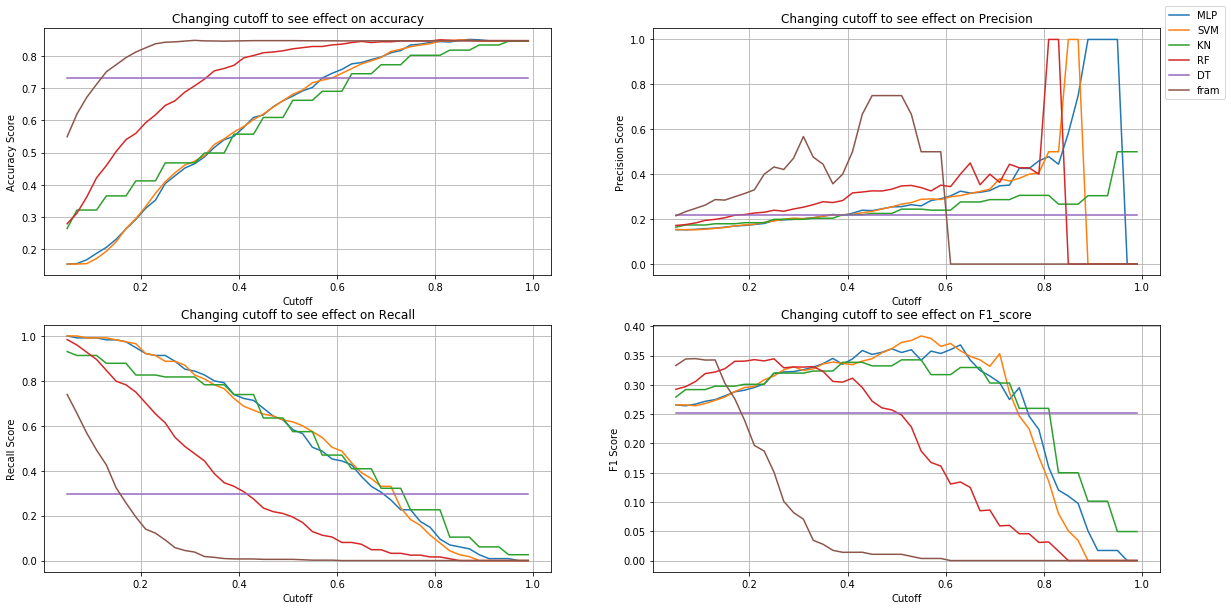

In [14]:
#PLOTS 
plt.figure(figsize=(20, 10))
range_x = np.arange(0.05, 1, 0.02)
plt.subplot(2,2,1)
plt.plot(range_x, resultsMLP['accuracy'], label='MLP')
plt.plot(range_x, resultsSVM['accuracy'], label='SVM')
plt.plot(range_x, resultsKN['accuracy'], label ='KN')
plt.plot(range_x, resultsRF['accuracy'], label ='RF')
plt.plot(range_x, resultsDT['accuracy'], label ='DT')
plt.plot(range_x, results_fram['accuracy'], label ='fram' )


plt.grid()
plt.title('Changing cutoff to see effect on accuracy')
plt.xlabel('Cutoff')
plt.ylabel('Accuracy Score')


plt.subplot(2,2,2)
#Precision Graph 
plt.plot(range_x, resultsMLP['precision'], label='MLP')
plt.plot(range_x, resultsSVM['precision'], label='SVM')
plt.plot(range_x, resultsKN['precision'], label ='KN') 
plt.plot(range_x, resultsRF['precision'], label ='RF')
plt.plot(range_x, resultsDT['precision'], label ='DT')
plt.plot(range_x, results_fram['precision'], label ='fram' )

plt.grid()
plt.title('Changing cutoff to see effect on Precision')
plt.xlabel('Cutoff')
plt.ylabel('Precision Score')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))

#Recall Graph 
plt.subplot(2,2,3)
plt.plot(range_x, resultsMLP['recall'], label='MLP')
plt.plot(range_x, resultsSVM['recall'], label='SVM')
plt.plot(range_x, resultsKN['recall'], label ='KN')
plt.plot(range_x, resultsRF['recall'], label ='RF')
plt.plot(range_x, resultsDT['recall'], label ='DT')
plt.plot(range_x, results_fram['recall'], label ='fram' )

plt.grid()
plt.title('Changing cutoff to see effect on Recall')
plt.xlabel('Cutoff')
plt.ylabel('Recall Score')

#F1_score Graph 
plt.subplot(2,2,4)
plt.plot(range_x, resultsMLP['f1'], label='MLP')
plt.plot(range_x, resultsSVM['f1'], label='SVM')
plt.plot(range_x, resultsKN['f1'], label ='KN')
plt.plot(range_x, resultsRF['f1'], label ='RF')
plt.plot(range_x, resultsDT['f1'], label ='DT')
plt.plot(range_x, results_fram['f1'], label ='fram' )

plt.grid()
plt.title('Changing cutoff to see effect on F1_score')
plt.xlabel('Cutoff')
plt.ylabel('F1 Score')


# ROC curve

roc auc for KN: 0.6614310167750771
roc auc for SVM: 0.7004519000342349
roc auc for MLP: 0.6995138651146868
roc auc for RF: 0.6875058101701218
roc auc for DT: 0.5540926838337826
roc auc for framingham: 0.6877080249204374


Text(0, 0.5, 'True positive rate (Sensitivity)')

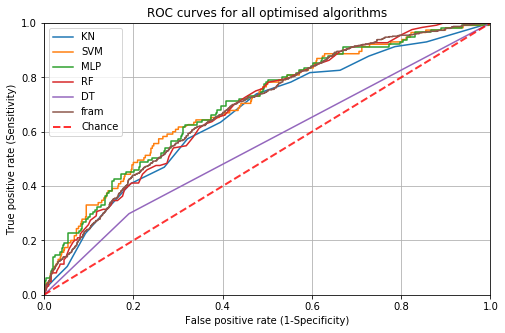

In [15]:
#ROC CURVE
plt.figure(figsize = (8,5))


#K-Neighbors
fpr, tpr, thresholds = roc_curve(y_test_KN, ROC_KN[:,1])
plt.plot(fpr,tpr,label ='KN')
print('roc auc for KN:',roc_auc_score(y_test_KN,ROC_KN[:,1]))

#SVM
fpr, tpr, thresholds = roc_curve(y_test_SVM, ROC_SVM[:,1])
plt.plot(fpr,tpr,label ='SVM')
print('roc auc for SVM:',roc_auc_score(y_test_SVM,ROC_SVM[:,1]))


#MLP
fpr, tpr, thresholds = roc_curve(y_test_MLP, ROC_MLP[:,1])
plt.plot(fpr,tpr,label ='MLP')
print('roc auc for MLP:',roc_auc_score(y_test_MLP,ROC_MLP[:,1]))

#RF
fpr, tpr, thresholds = roc_curve(y_test_RF, ROC_RF[:,1])
plt.plot(fpr,tpr,label ='RF')
print('roc auc for RF:',roc_auc_score(y_test_RF,ROC_RF[:,1]))

#DT
fpr, tpr, thresholds = roc_curve(y_test_DT, ROC_DT[:,1])
plt.plot(fpr,tpr,label ='DT')
print('roc auc for DT:',roc_auc_score(y_test_DT,ROC_DT[:,1]))

#framingham dataset 
fpr, tpr, thresholds = roc_curve(df_fram.TenYearCHD, df_fram.fram_percent)
plt.plot(fpr,tpr,label ='fram')
print('roc auc for framingham:',roc_auc_score(df_fram.TenYearCHD, df_fram.fram_percent))



plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=.8)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend()
plt.grid()
plt.title('ROC curves for all optimised algorithms')
plt.xlabel('False positive rate (1-Specificity)')
plt.ylabel('True positive rate (Sensitivity)')


# Confusion matrix for all alogrithms

Text(0.5, 1.0, 'RF ')

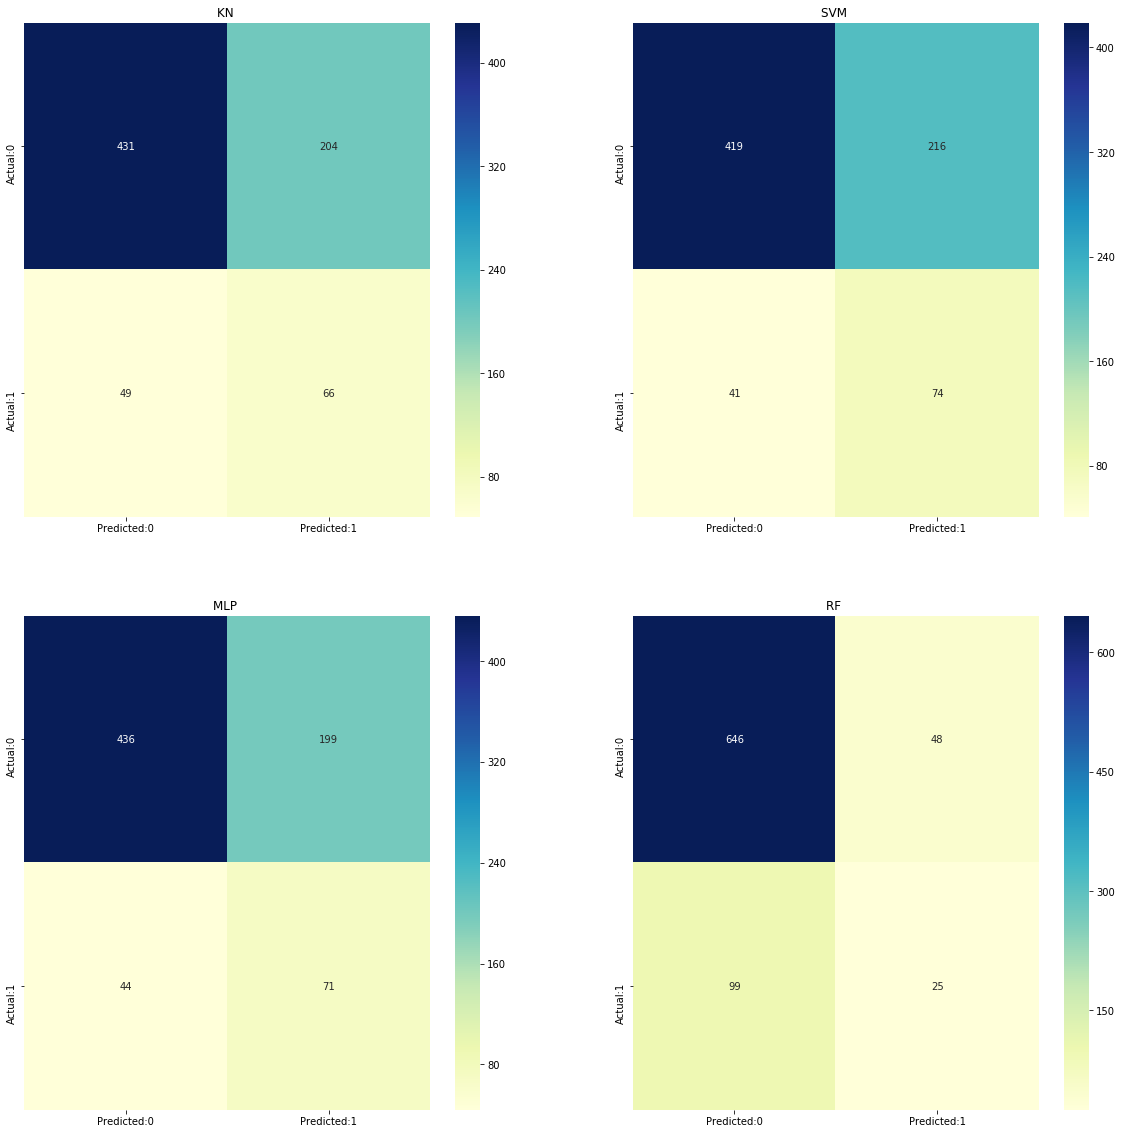

In [16]:
cm_KN  = pd.DataFrame(data=cm_KN,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
cm_SVM = pd.DataFrame(data=cm_SVM,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
cm_MLP = pd.DataFrame(data=cm_MLP,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
cm_RF = pd.DataFrame(data=cm_RF,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])


plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
sn.heatmap(cm_KN, annot=True, fmt='d', cmap="YlGnBu")
plt.title('KN ')

plt.subplot(2,2,2)
sn.heatmap(cm_SVM, annot=True,fmt='d',cmap="YlGnBu")
plt.title('SVM ')


plt.subplot(2,2,3)
sn.heatmap(cm_MLP, annot=True,fmt='d',cmap="YlGnBu")
plt.title('MLP ')

plt.subplot(2,2,4)
sn.heatmap(cm_RF, annot=True,fmt='d',cmap="YlGnBu")
plt.title('RF ')



In [ ]:
results_fram = fram_analysis(df_fram)